# H1C Systematics Mitigation (Reflections & Crosstalk) Nightly Notebook

**Josh Dillon**, Last Revised 4/29/22

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from hera_cal import io, redcal, apply_cal, abscal, utils, datacontainer
from hera_cal.smooth_cal import build_time_blacklist
from hera_qm.metrics_io import load_metric_file
from hera_cal.frf import FRFilter
import pyuvdata
import glob
import os
from copy import deepcopy
import inspect
import h5py
import matplotlib.cm as cm
from IPython.display import display, HTML
import contextlib
import scipy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# If you want to run this notebook locally, copy the output of the next cell into the first few lines of this cell.
# JD = "2458187"
# data_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_3/2458187"
# horizon = "1.0"
# standoff = "0.0"
# min_dly = "150.0"
# max_frate_const_term = "-0.28"
# max_frate_linear_term = "0.024"
# min_frate_half_width = "0.06"
# max_frate_half_width = "0.75"
# os.environ["JULIANDATE"] = JD
# os.environ["DATA_PATH"] = data_path
# os.environ["HORIZON"] = horizon
# os.environ["STANDOFF"] = standoff
# os.environ["MIN_DLY"] = min_dly
# os.environ["MAX_FRATE_CONST_TERM"] = max_frate_const_term
# os.environ["MAX_FRATE_LINEAR_TERM"] = max_frate_linear_term
# os.environ["MIN_FRATE_HALF_WIDTH"] = min_frate_half_width
# os.environ["MAX_FRATE_HALF_WIDTH"] = max_frate_half_width

In [3]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
horizon = float(os.environ["HORIZON"])
standoff = float(os.environ["STANDOFF"])
min_dly = float(os.environ["MIN_DLY"])
max_frate_const_term = float(os.environ["MAX_FRATE_CONST_TERM"])
max_frate_linear_term = float(os.environ["MAX_FRATE_LINEAR_TERM"])
min_frate_half_width = float(os.environ["MIN_FRATE_HALF_WIDTH"])
max_frate_half_width = float(os.environ["MAX_FRATE_HALF_WIDTH"])

print(f'JD = "{JD}"')
print(f'data_path = "{data_path}"')
print(f'horizon = "{horizon}"')
print(f'standoff = "{standoff}"')
print(f'min_dly = "{min_dly}"')
print(f'max_frate_const_term = "{max_frate_const_term}"')
print(f'max_frate_linear_term = "{max_frate_linear_term}"')
print(f'min_frate_half_width = "{min_frate_half_width}"')
print(f'max_frate_half_width = "{max_frate_half_width}"')

JD = "2458059"
data_path = "/lustre/aoc/projects/hera/H1C_IDR3/IDR3_3/2458059"
horizon = "1.0"
standoff = "0.0"
min_dly = "150.0"
max_frate_const_term = "-0.28"
max_frate_linear_term = "0.024"
min_frate_half_width = "0.06"
max_frate_half_width = "0.75"


In [4]:
print(f'Looking for data in {data_path} on {JD}...')

smooth_cal_files = sorted(glob.glob(os.path.join(data_path, f'*.smooth_abs.calfits')))
print(f'...found {len(smooth_cal_files)} smoothed calibration files.')

total_flags_files = sorted(glob.glob(os.path.join(data_path, '*.total_threshold_and_a_priori_flags.h5')))
print(f'...found {len(total_flags_files)} total thresholding and apriori flags files.')

ref_cal_files = sorted(glob.glob(os.path.join(data_path, '*.time_avg_ref_cal.calfits')))
print(f'...found {len(ref_cal_files)} time-averaged reflection calibration files.')

inpainted_autos_files = sorted(glob.glob(os.path.join(data_path, '*.autos.inpainted.uvh5')))
print(f'...found {len(inpainted_autos_files)} CLEAN-inpainted autocorrelation files.')

final_cal_files = sorted(glob.glob(os.path.join(data_path, '*.final_calibrated.uvh5')))
print(f'...found {len(final_cal_files)} smooth-calibrated and reflection-calibrated data files.')

dpss_filled_files = sorted(glob.glob(os.path.join(data_path, '*.dpss_filled.uvh5')))
print(f'...found {len(dpss_filled_files)} DPSS inpainted files.')

dpss_res_files = sorted(glob.glob(os.path.join(data_path, '*.dpss_res.uvh5')))
print(f'...found {len(dpss_res_files)} DPSS delay-filtered files.')

dpss_res_xtalk_filt_files = sorted(glob.glob(os.path.join(data_path, '*.dpss_res.xtalk_filt.uvh5')))
print(f'...found {len(dpss_res_xtalk_filt_files)} DPSS delay-filtered, DPSS crosstalk-filtered files.')

Looking for data in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_3/2458059 on 2458059...
...found 73 smoothed calibration files.
...found 1 total thresholding and apriori flags files.
...found 1 time-averaged reflection calibration files.
...found 73 CLEAN-inpainted autocorrelation files.
...found 73 smooth-calibrated and reflection-calibrated data files.
...found 73 DPSS inpainted files.
...found 73 DPSS delay-filtered files.
...found 73 DPSS delay-filtered, DPSS crosstalk-filtered files.


In [5]:
# Load information about antenna positions and antenna flags
hc = io.HERACal(smooth_cal_files[len(smooth_cal_files) // 2])
_, sc_flags, _, _ = hc.read()
ex_ants = set([ant[0] for ant in sc_flags if np.all(sc_flags[ant])])
hd = io.HERAData(final_cal_files[len(final_cal_files) // 2])

In [6]:
# Pick group of 4 antennas in a row as close as possible to the emitter
candidates = []
for i, ant in enumerate(hd.data_ants):
    if np.all([((ant + n) in hd.data_ants) and ((ant + n) not in ex_ants) for n in range(4)]):
        y_positions = [hd.antpos[ant + n][1] for n in range(4)]
        if np.max(y_positions) - np.min(y_positions) < 5:
            candidates.append(ant)
westernmost_ant = sorted(candidates, key=lambda ant: np.linalg.norm(hd.antpos[ant] - np.array([-180, -10, 0])))[0]
ants_to_load = [westernmost_ant + n for n in range(4)]

IndexError: list index out of range

IndexError: invalid index to scalar variable.

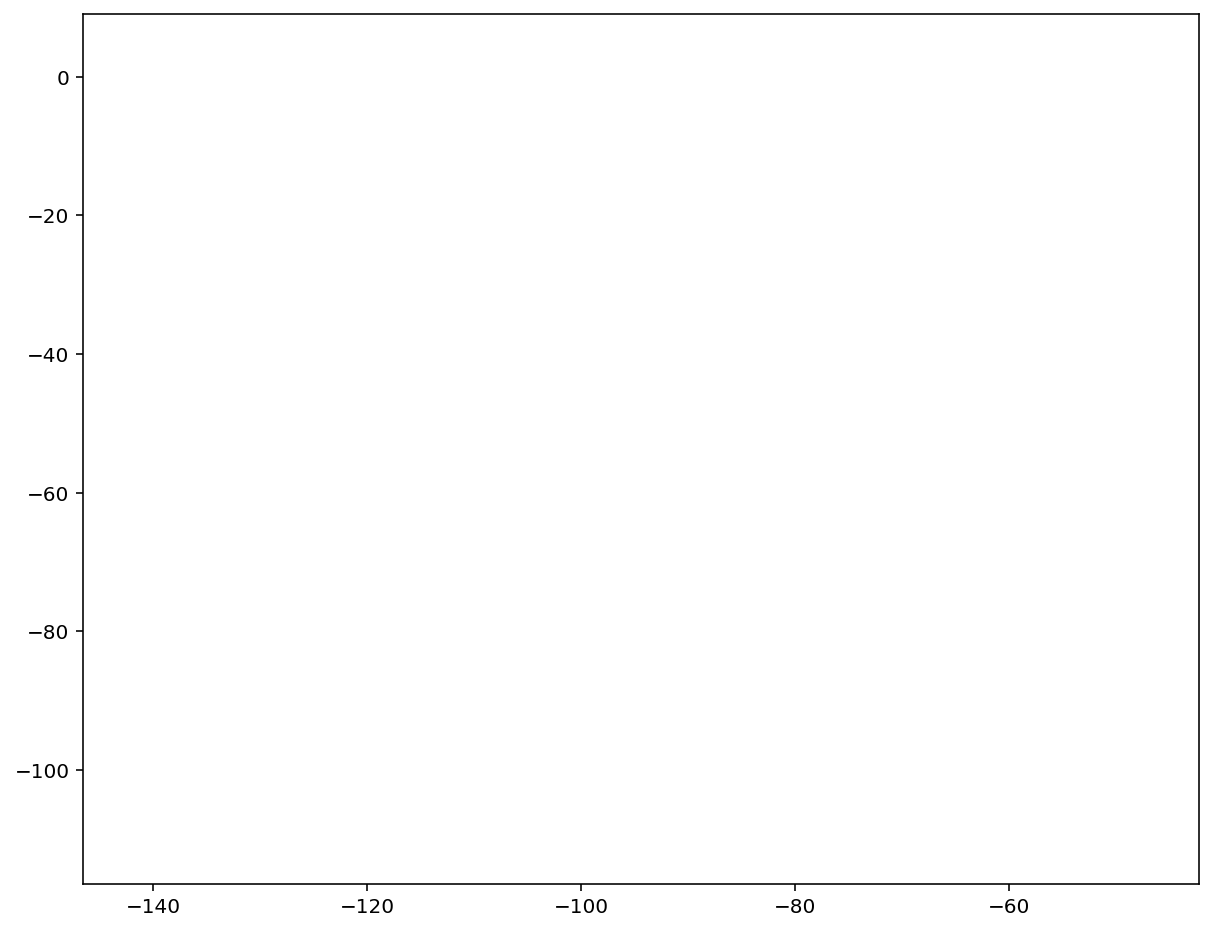

In [7]:
plt.figure(figsize=(10,8))
xpos = np.array([hd.antpos[ant][0] for ant in hd.data_ants])
ypos = np.array([hd.antpos[ant][1] for ant in hd.data_ants])
plt.scatter(xpos, ypos, c='w', s=0)
for ant in hd.data_ants:
    pos = hd.antpos[ant]
    bad = ant in [ant[0] for ant in ex_ants]
    plt.gca().add_artist(plt.Circle(tuple(pos[0:2]), radius=7, 
                                    fill=(~bad), color=['grey','r'][bad]))
    if ant in ants_to_load:
        plt.gca().add_artist(plt.Circle(tuple(hd.antpos[ant][0:2]), radius=7, fill=True, lw=0, color='b'))
        plt.gca().add_artist(plt.Circle(tuple(hd.antpos[ant][0:2]), radius=6, fill=True, color='grey'))        
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w', size=14)        
        
legend_objs = []
legend_labels = []
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='grey', markerfacecolor='grey', markersize=13))
legend_labels.append(f'{len(hd.data_ants) - len(ex_ants)} Unflagged Antennas')
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgecolor='r', markerfacecolor='r', markersize=13))
legend_labels.append(f'{len(ex_ants)} Flagged Antennas')
legend_objs.append(matplotlib.lines.Line2D([0], [0], marker='o', color='w', markeredgewidth=2, markeredgecolor='b', markersize=15))
legend_labels.append('Antennas Inspected\nIn This Notebook')
plt.legend(legend_objs, legend_labels, ncol=1, fontsize='large', framealpha=1)


plt.xlabel("Antenna East-West Position (meters)", size=14)
plt.ylabel("Antenna North-South Position (meters)", size=14)
plt.axis('equal')
plt.ylim([np.min(ypos)-10, np.max(ypos)+10])
plt.tight_layout()
plt.show()

### Figure 1: Array and Flagged Antennas
This figure also shows which antennas are examined in the rest of this notebook. They were chosen to be 4 neighboring, unflagged antennas in a line, as close as possible to the receiverators (the likely crosstalk emitter).

In [8]:
# Figure out baselines to load
hd_final_cal = io.HERAData(final_cal_files[len(final_cal_files) // 2])
bls = hd_final_cal.bls
bls_to_load = [bl for bl in bls if bl[0] in ants_to_load and bl[1] in ants_to_load and bl[2] in ['ee', 'nn']]
auto_bls = [bl for bl in bls_to_load if utils.split_bl(bl)[0] == utils.split_bl(bl)[1]]
example_bl = sorted(bls_to_load, key=lambda bl: np.linalg.norm(hd_final_cal.antpos[bl[0]] - hd_final_cal.antpos[bl[1]]))[-1]  #i.e. the longest baseline

NameError: name 'ants_to_load' is not defined

In [9]:
# Figure out the Horizon, Delay Filter Width, and FRF width for each baseline
blvecs = {bl: hd_final_cal.antpos[bl[1]] - hd_final_cal.antpos[bl[0]] for bl in bls_to_load} # in m
horizons = {bl: np.linalg.norm(blvecs[bl]) / scipy.constants.c * 1e9 for bl in bls_to_load} # in ns
delay_filter_half_width = {bl: max(min_dly, horizons[bl] * horizon + standoff) for bl in bls_to_load} # in ns
frf_half_width = {bl: max_frate_const_term + max_frate_linear_term * np.abs(blvecs[bl][0]) for bl in bls_to_load} # in mHz
frf_half_width = {bl: min(max_frate_half_width, max(min_frate_half_width, frf_half_width[bl])) for bl in bls_to_load} # in mHz

NameError: name 'bls_to_load' is not defined

In [10]:
# Figure out how many channels/integrations are completely flagged on both ends
final_flag_waterfall = np.squeeze(pyuvdata.UVFlag(total_flags_files).flag_array)

def count_edge_flags(flag_wf):
    unflagged_channels = np.arange(flag_wf.shape[1])[~np.all(flag_wf, axis=0)]
    ecf_low = unflagged_channels[0]
    ecf_high = flag_wf.shape[1] - unflagged_channels[-1] - 1

    unflagged_ints = np.arange(flag_wf.shape[0])[~np.all(flag_wf, axis=1)]
    ect_low = unflagged_ints[0]
    ect_high = flag_wf.shape[0] - unflagged_ints[-1] - 1
    return ect_low, ect_high, ecf_low, ecf_high

ect_low, ect_high, ecf_low, ecf_high = count_edge_flags(final_flag_waterfall)

print(f'There are {ect_low} edge integrations flagged at the start of the night and {ect_high} at the end of the night.')
print(f'There are {ecf_low} edge channels flagged at the low end and {ecf_high} at the high end.')

There are 2852 edge integrations flagged at the start of the night and 105 at the end of the night.
There are 96 edge channels flagged at the low end and 195 at the high end.


## Examine Reflection Calibration

In [11]:
# Load reflection calibration
hcr = io.HERACal(ref_cal_files)
ref_cal_gains, ref_cal_flags, _, _ = hcr.read()

telescope_location is not set. Using known values for HERA.
antenna_positions is not set. Using known values for HERA.


In [12]:
# Load inpainted autocorrelations
hd_ip_autos = io.HERAData(inpainted_autos_files)
hd_ip_autos.read(bls=auto_bls, return_data=False)

NameError: name 'auto_bls' is not defined

In [13]:
# Time-average autocorrelations (and FT them)
F = FRFilter(hd_ip_autos)
F.timeavg_data(F.data, F.times, F.lsts, flags=F.flags, t_avg=1e10, overwrite=True)
F.fft_data(data=F.avg_data, flags=F.avg_flags, assign='avg_fft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
avg_data, avg_flags = deepcopy(F.avg_data), deepcopy(F.avg_flags)

# Time-average autocorrelations with reflection calibration (and FT them)
apply_cal.calibrate_in_place(F.data, ref_cal_gains, data_flags=F.flags, cal_flags=ref_cal_flags)
F.timeavg_data(F.data, F.times, F.lsts, flags=F.flags, t_avg=1e10, overwrite=True)
F.fft_data(data=F.avg_data, flags=F.avg_flags, assign='avg_ref_cal_fft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)

AttributeError: 'FRFilter' object has no attribute 'data'

NameError: name 'ants_to_load' is not defined

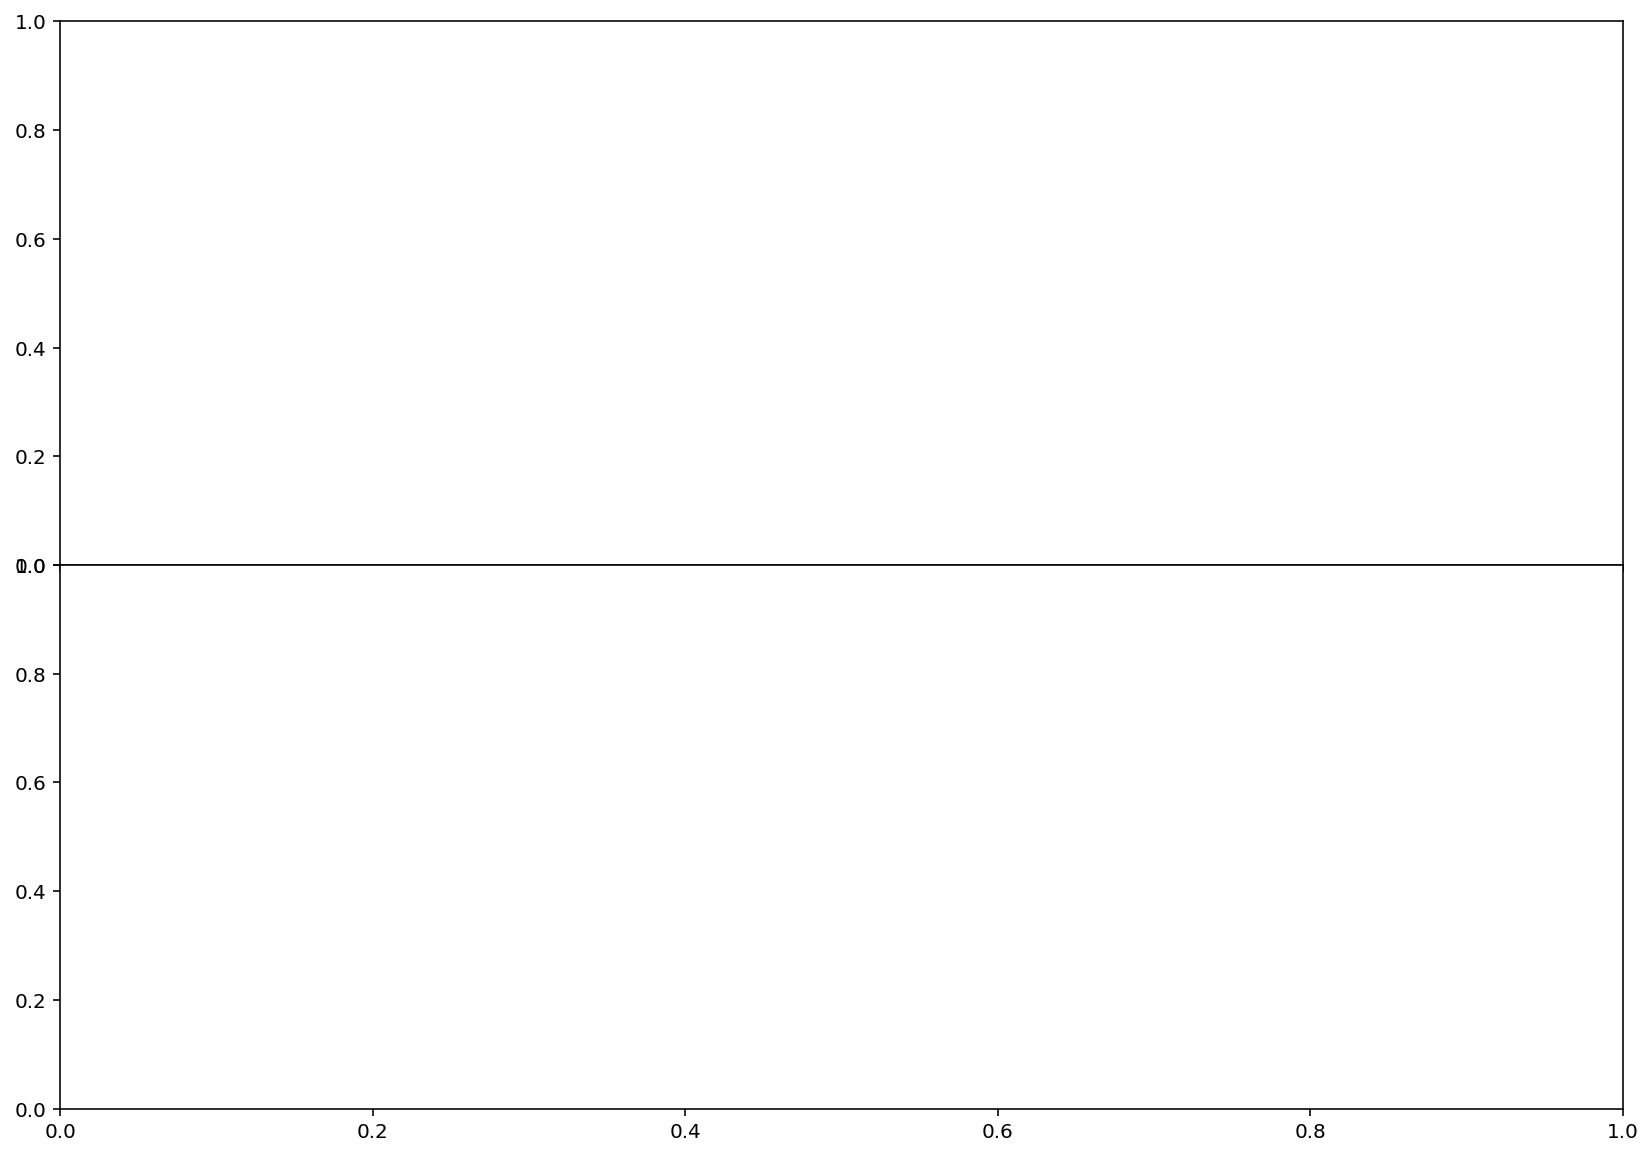

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14,10), sharex=True, gridspec_kw={'hspace': 0})
for i, (pol, ax) in enumerate(zip(F.pols, axes)):
    abl = (ants_to_load[0], ants_to_load[0], pol)
    ax.semilogy(F.freqs / 1e6, np.where(np.all(final_flag_waterfall, axis=0), np.nan, np.squeeze(np.abs(avg_data[abl]))),
                c='C1', lw=2, label=f'{abl} Smooth Calibrated')
    ax.semilogy(F.freqs / 1e6, np.where(np.all(final_flag_waterfall, axis=0), np.nan, np.squeeze(np.abs(F.avg_data[abl]))),
                c='C0', lw=1, label=f'{abl} Reflection Calibrated')
    ax.legend()
    ax.set_ylabel('Time-Averaged $|V_{ii}|$ (Jy)')
    ax.set_xlabel('Frequency (MHz)') 

### Figure 2: Demonstration of Reflection Calibration

This figure shows how reflection calibration works on a single example antenna's autocorrelations (both polarizations). The autocorrelations are inpainted in frequency with CLEAN before being fit with a single time-independent reflection solution.

AttributeError: 'FRFilter' object has no attribute 'data'

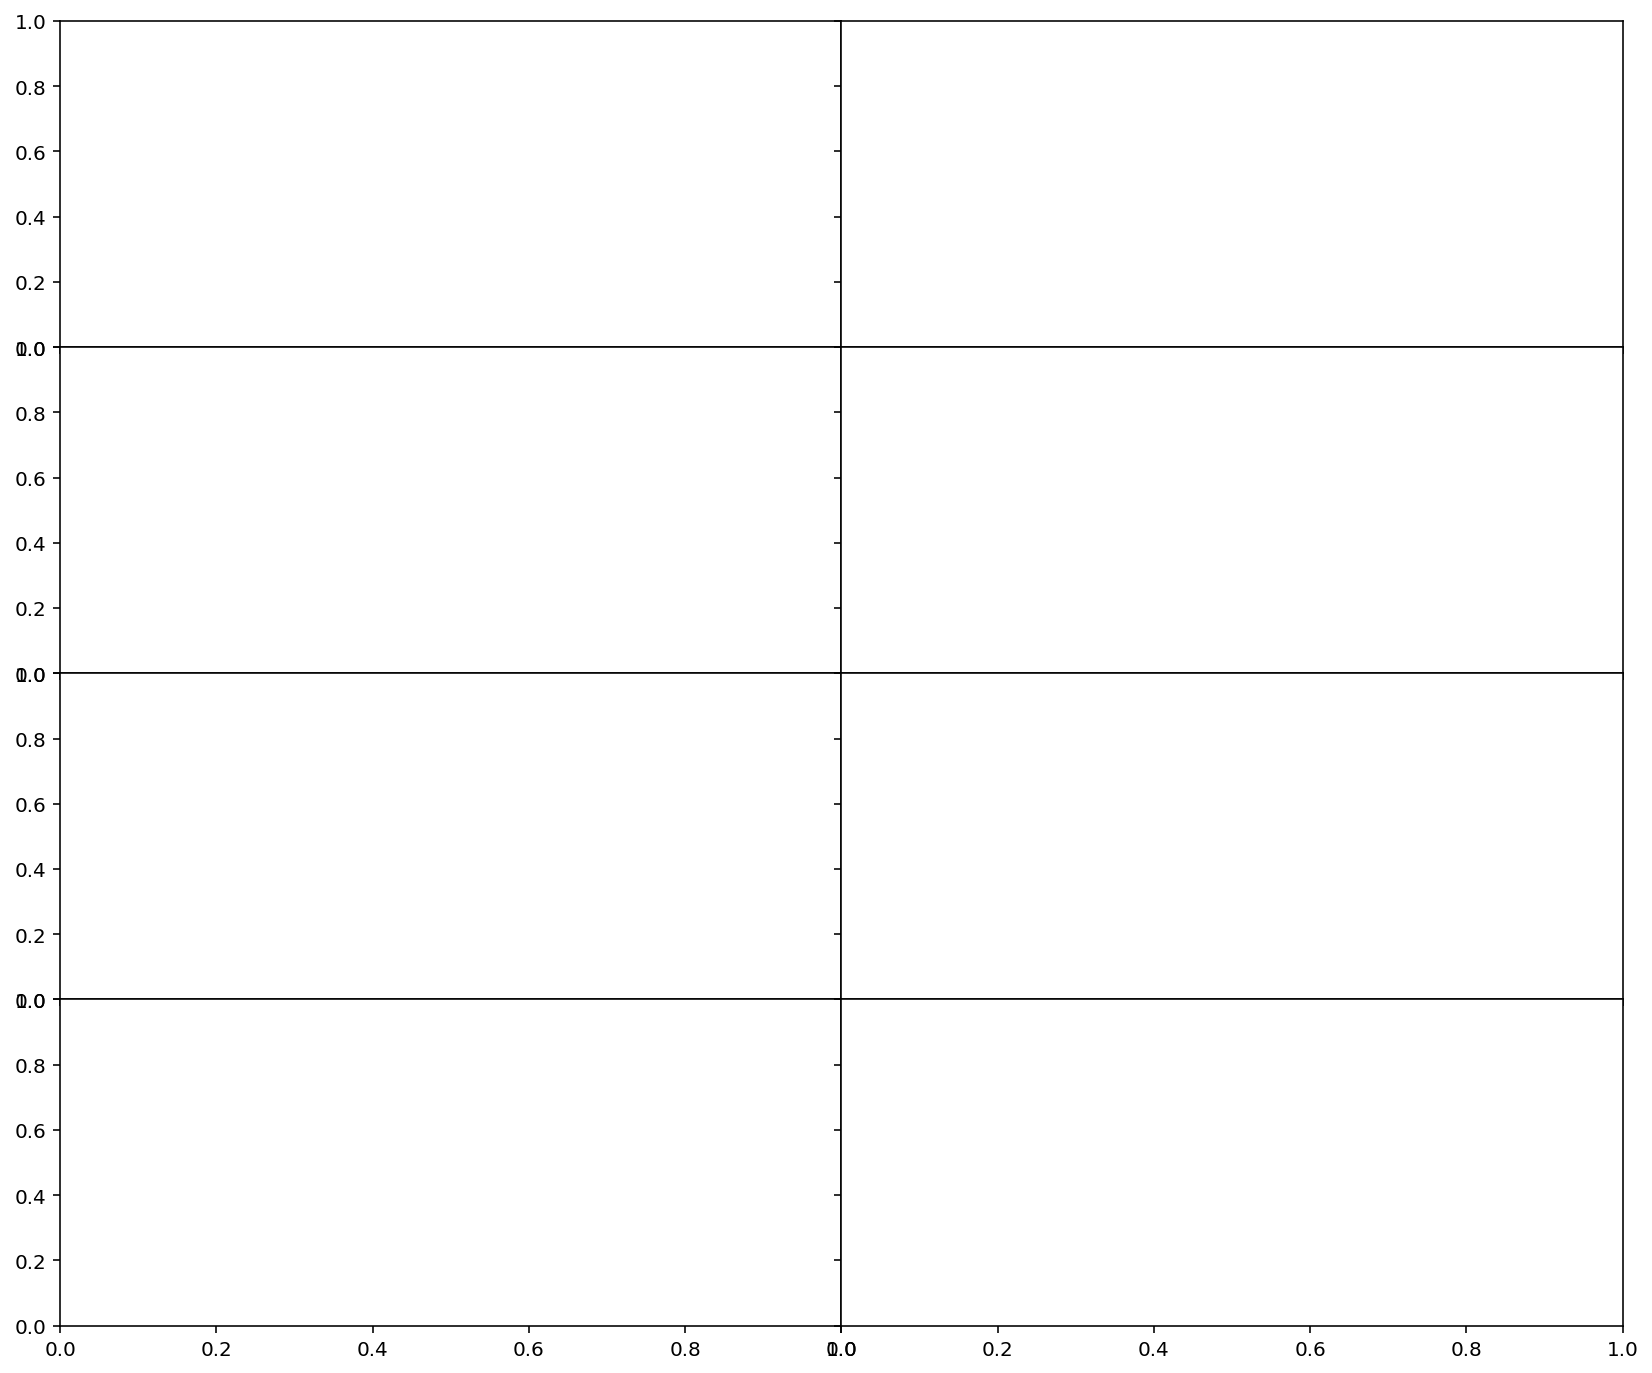

In [15]:
# Plot delay spectra of autocorrelations with and without reflection calibration
fig, axes = plt.subplots(4, 2, figsize=(14,12), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
for i, (abl, ax) in enumerate(zip(F.data, axes.flatten())):
    ax.semilogy(F.delays, np.abs(np.squeeze(F.avg_fft[abl])), c='C1', label=f'{abl} Inpainted')
    ax.semilogy(F.delays, np.abs(np.squeeze(F.avg_ref_cal_fft[abl])), c='C0', lw=.5, label=f'{abl} Ref Cal')
    ax.legend()
    ax.set_xlim([-3999, 3999])
    if i >= 6:
        ax.set_xlabel('Delay (ns)')
    if i % 2 == 0:
        ax.set_ylabel('$|\\widetilde{V}_{ii}|$  [Jy Hz]')
    
plt.tight_layout()

### Figure 3: Autocorrelation Delay Spectra, Before and After Reflection Calibration

These delay spectra and time-averaged, delay-inpainted autocorrleations before and after reflection calibration. Ideally they the same power at 0 and high delay, but reduced power at low to medium delay.

## Load Waterfalls

In [16]:
# load dpss residual data
hd_dpss_res = io.HERAData(dpss_res_files)
hd_dpss_res.read(bls=bls_to_load, axis='blt', return_data=False)

NameError: name 'bls_to_load' is not defined

In [17]:
# load dpss filled data
hd_dpss_filled = io.HERAData(dpss_filled_files)
hd_dpss_filled.read(bls=bls_to_load, axis='blt', return_data=False)

NameError: name 'bls_to_load' is not defined

In [18]:
# load dpss filled, dpss crosstalk filtered data
hd_dpss_res_xtalk_filt = io.HERAData(dpss_res_xtalk_filt_files)
hd_dpss_res_xtalk_filt.read(bls=bls_to_load, axis='blt', return_data=False)

NameError: name 'bls_to_load' is not defined

TypeError: 'NoneType' object is not subscriptable

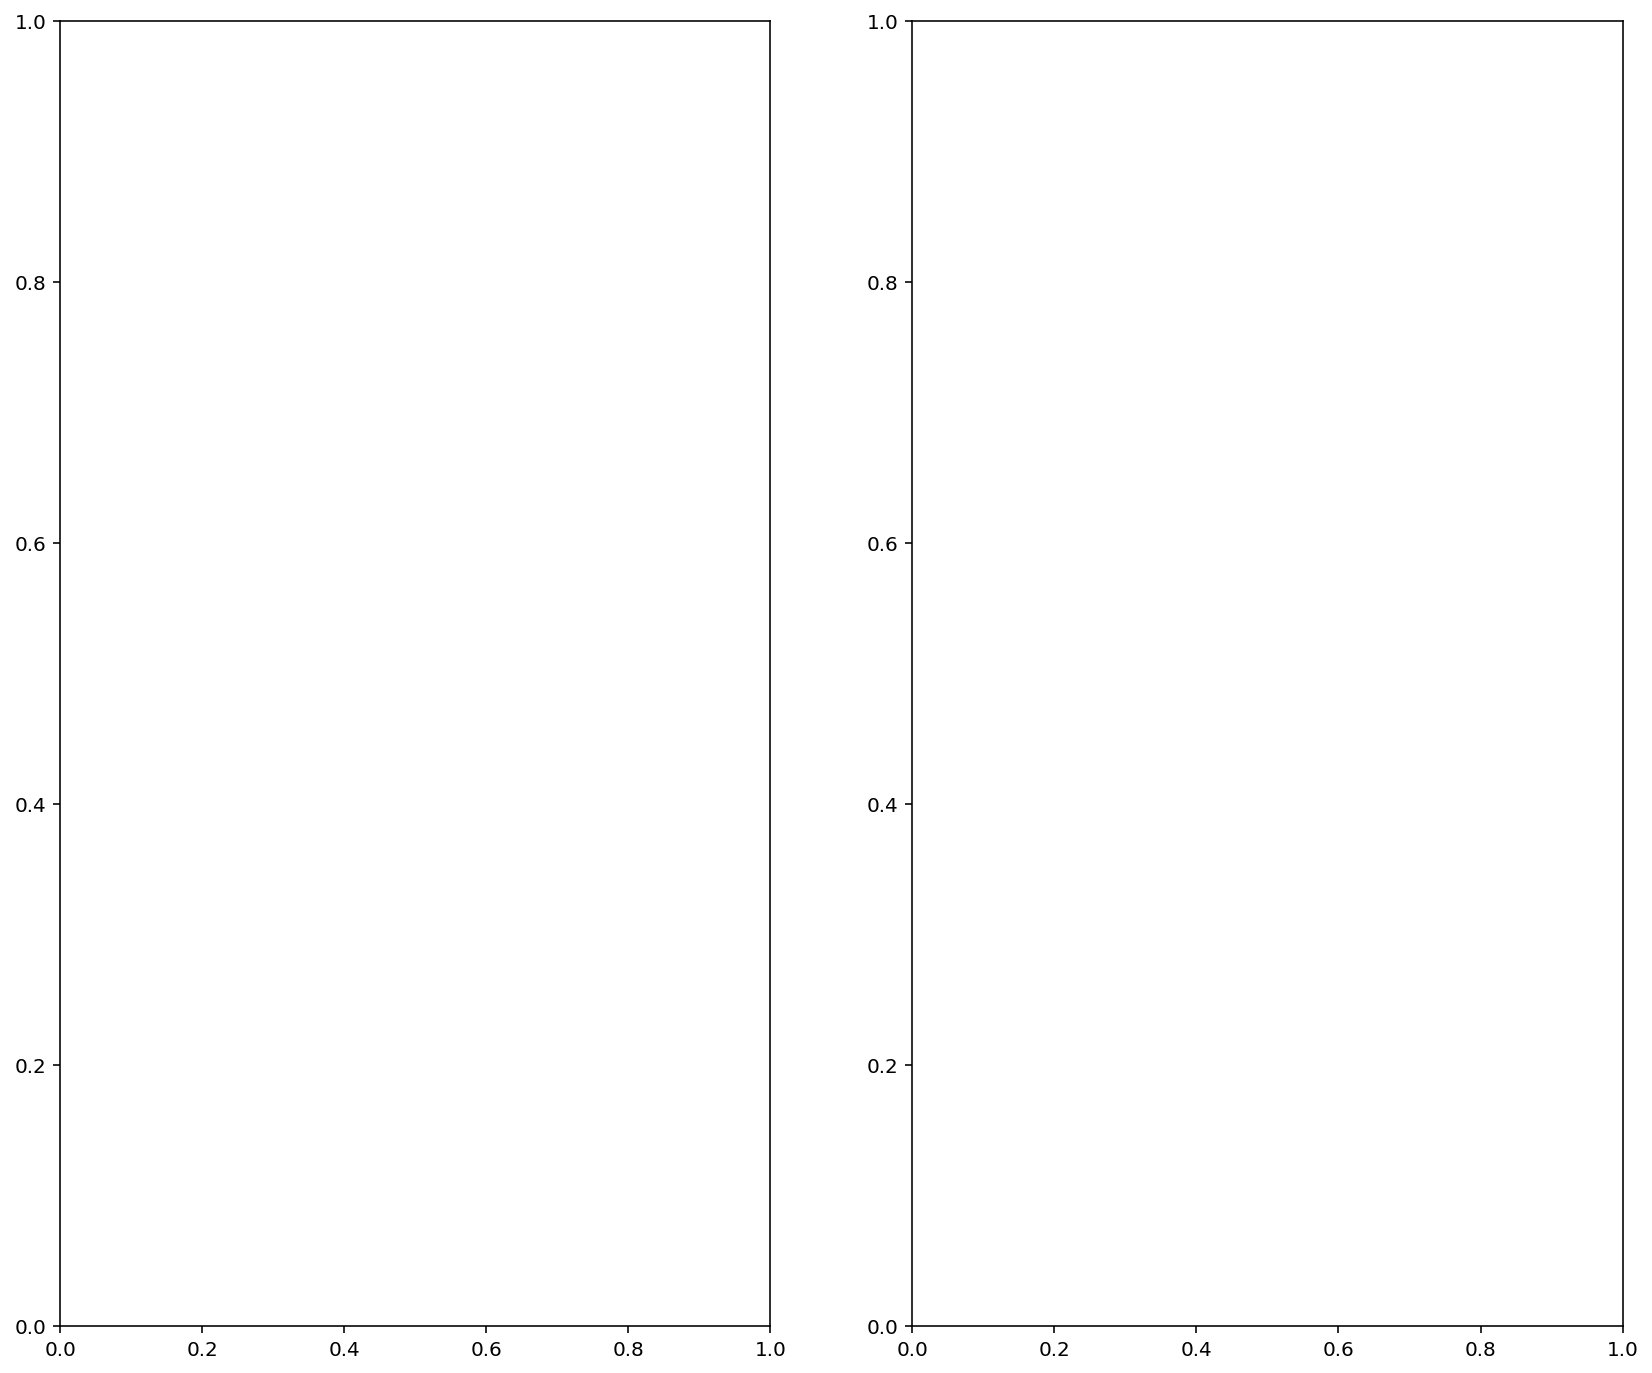

In [19]:
# plot example waterfall of final calibrated data, both abs and angle
fig, axes = plt.subplots(1, 2, figsize=(14,12))

d, f, n = hd_dpss_filled.build_datacontainers()
lsts_unwrapped = np.where(d.lsts > d.lsts[-1], d.lsts - 2 * np.pi, d.lsts) * 12 / np.pi  # in hours
extent = [d.freqs[0] / 1e6, d.freqs[-1] / 1e6, lsts_unwrapped[-1], lsts_unwrapped[0]]

im = axes[0].imshow(np.where(final_flag_waterfall, np.nan, np.abs(d[example_bl])), aspect='auto', interpolation='none', 
                   norm=matplotlib.colors.LogNorm(), cmap='inferno', extent=extent)
plt.colorbar(im, ax=axes[0], label='$|V_{ij}|$ (Jy)')
axes[0].set_title(f'Final Calibrated Amplitude of {example_bl}')

im = axes[1].imshow(np.where(final_flag_waterfall, np.nan, np.angle(d[example_bl])), aspect='auto', interpolation='none', 
                    cmap='twilight', extent=extent)
plt.colorbar(im, ax=axes[1], label='Angle($V_{ij})$ (radians)')
axes[1].set_title(f'Final Calibrated Phase of {example_bl}')

for ax in axes:
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('LST (hours)')
plt.tight_layout()

### Figure 4: Full-Day, Final Calibrated Amplitude and Phase of an Example Baseline
This is after reflection calibration but before any delay or crosstalk filtering.

## Examine DPSS-Inpainted Visibilities

In [20]:
# FFT visibilities in 1D and 2D
F_filled = FRFilter(hd_dpss_filled)
F_filled.fft_data(data=F_filled.data, assign='dfft', ax='freq', window='bh', 
                  edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_filled.vis_clean(data=F_filled.data, flags=F_filled.flags, keys=[example_bl], ax='time', max_frate=5, tol=1e-6, gain=0.9,
                   window='bh', alpha=0.1, overwrite=True, verbose=True, x=F_filled.times*24*3600, output_prefix='xclean')
F_filled.fft_data(data=F_filled.xclean_data, keys=[example_bl], assign='xdfft2', ax='both', window=('bh','bh'), 
                  edgecut_low=(ect_low, ecf_low), edgecut_hi=(ect_high, ecf_high), overwrite=True)

AttributeError: 'FRFilter' object has no attribute 'data'

In [21]:
# plot real part of DPSS inpainted example waterfall
lsts_unwrapped = np.where(F_filled.lsts > F_filled.lsts[-1], F_filled.lsts - 2 * np.pi, F_filled.lsts) * 12 / np.pi  # in hours
extent = [F_filled.freqs[0]/1e6, F_filled.freqs[-1]/1e6, lsts_unwrapped[-1], lsts_unwrapped[0]]

def sym_log_norm(to_plot):
    '''Shortcut for symmetric sym log norm.'''
    return matplotlib.colors.SymLogNorm(10, vmin=-np.nanmax(np.abs(to_plot)), vmax=np.nanmax(np.abs(to_plot)))

plt.figure(figsize=(14,8))
to_plot = np.where(F_filled.flags[example_bl], np.nan, F_filled.data[example_bl]).real
plt.imshow(to_plot, aspect='auto', interpolation='none',  cmap='bwr', extent=extent, norm=sym_log_norm(to_plot))
plt.colorbar(label='Re$[V_{ij}]$ (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (Hours)')
plt.title(f'Final Calibrated, DPSS Inpainted Visibility: {example_bl}')
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'flags'

<Figure size 1008x576 with 0 Axes>

### Figure 5a: Real Part of DPSS-Inpainted Example Waterfall

In [22]:
def delay_lines(ax, horizon_dly, df_half_width):
    ax.axvline(horizon_dly, c='k', ls='-', lw=1, label='Horizon')    
    ax.axvline(-horizon_dly, c='k', ls='-', lw=1)
    ax.axvline(df_half_width, c='grey', ls='--', lw=1, label='Delay Filter')
    ax.axvline(-df_half_width, c='grey', ls='--', lw=1)

In [23]:
# plot in delay space
plt.figure(figsize=(14,8))
to_plot = np.where(np.all(F_filled.flags[example_bl], axis=1, keepdims=True), np.nan, np.real(F_filled.dfft[example_bl]))
plt.imshow(to_plot, interpolation='none', aspect='auto', cmap='bwr', norm=sym_log_norm(to_plot),
           extent=[F_filled.delays[0], F_filled.delays[-1], lsts_unwrapped[-1], lsts_unwrapped[0]])
plt.xlim([-2000, 2000])
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.colorbar(label=r'Re$[\widetilde{V}_{ij}]$ (Jy Hz)')
plt.title(f'Final Calibrated, DPSS Inpainted Visibility: {example_bl}')
delay_lines(plt.gca(), horizons[example_bl], delay_filter_half_width[example_bl])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'flags'

<Figure size 1008x576 with 0 Axes>

### Figure 5b: Real Part of DPSS-Inpainted Example Waterfall in Delay Space

In [24]:
def fr_lines(ax, half_width):
    ax.axhline(half_width, c='grey', ls=':', lw=1, label='FR Filter')
    ax.axhline(-half_width, c='grey', ls=':', lw=1)

In [25]:
# plot in delay space and FR space
extent = [F_filled.delays[0], F_filled.delays[-1], F_filled.frates[-1], F_filled.frates[0]]
plt.figure(figsize=(14,8))
plt.imshow(np.abs(F_filled.xdfft2[example_bl]), aspect='auto', interpolation='none', 
           norm=matplotlib.colors.LogNorm(), cmap='turbo', extent=extent)
plt.colorbar(label='$|\widetilde{V}_{ij}|$ (Jy)')
plt.xlabel('Delay (ns)')
plt.xlim([-2000, 2000])
plt.ylim([-5, 5])
plt.ylabel('Fringe Rate (mHz)')
plt.title(f'Final Calibrated, DPSS Inpainted (in Frequency) and CLEAN Inpainted (in Time): {example_bl}')
delay_lines(plt.gca(), horizons[example_bl], delay_filter_half_width[example_bl])
fr_lines(plt.gca(), frf_half_width[example_bl])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'delays'

### Figure 5c: Magnitude of DPSS-Inpainted Example Waterfall in Fringe-Rate / Delay Space

## Examine DPSS-Residual Visibilities

In [26]:
# FFT visibilities in 1D and 2D
F_res = FRFilter(hd_dpss_res)
F_res.fft_data(data=F_res.data, assign='dfft', ax='freq', window='bh', 
               edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_res.vis_clean(data=F_res.data, flags=F_res.flags, keys=[example_bl], ax='time', max_frate=5, tol=1e-6, gain=0.9,
                   window='bh', alpha=0.1, overwrite=True, verbose=True, x=F_res.times*24*3600, output_prefix='xclean')
F_res.fft_data(data=F_res.xclean_data, keys=[example_bl], assign='xdfft2', ax='both', window=('bh','bh'), 
                  edgecut_low=(ect_low, ecf_low), edgecut_hi=(ect_high, ecf_high), overwrite=True)

AttributeError: 'FRFilter' object has no attribute 'data'

In [27]:
# plot real part of DPSS residual example waterfall
lsts_unwrapped = np.where(F_res.lsts > F_res.lsts[-1], F_res.lsts - 2 * np.pi, F_res.lsts) * 12 / np.pi  # in hours
extent = [F_res.freqs[0]/1e6, F_res.freqs[-1]/1e6, lsts_unwrapped[-1], lsts_unwrapped[0]]

plt.figure(figsize=(14,8))
to_plot = np.where(F_res.flags[example_bl], np.nan, F_res.data[example_bl]).real
plt.imshow(to_plot, aspect='auto', interpolation='none', norm=sym_log_norm(to_plot), cmap='bwr', extent=extent)
plt.colorbar(label='Re$[V_{ij}]$ (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (Hours)')
plt.title(f'Final Calibrated, DPSS Residual Visibility: {example_bl}')
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'flags'

<Figure size 1008x576 with 0 Axes>

### Figure 6a: Real Part of DPSS-Residual Example Waterfall

In [28]:
# plot in delay space
plt.figure(figsize=(14,8))
to_plot = np.where(np.all(F_res.flags[example_bl], axis=1, keepdims=True), np.nan, np.real(F_res.dfft[example_bl]))
plt.imshow(to_plot, interpolation='none', aspect='auto', cmap='bwr', norm=sym_log_norm(to_plot),
           extent=[F_res.delays[0], F_res.delays[-1], lsts_unwrapped[-1], lsts_unwrapped[0]])
plt.xlim([-2000, 2000])
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.colorbar(label=r'Re$[\widetilde{V}_{ij}]$ (Jy Hz)')
plt.title(f'Final Calibrated, DPSS Residual Visibility: {example_bl}')
delay_lines(plt.gca(), horizons[example_bl], delay_filter_half_width[example_bl])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'flags'

<Figure size 1008x576 with 0 Axes>

### Figure 6b: Real Part of DPSS-Residual Example Waterfall in Delay Space

In [29]:
# plot in delay space and FR space
extent = [F_res.delays[0], F_res.delays[-1], F_res.frates[-1], F_res.frates[0]]
plt.figure(figsize=(14,8))
plt.imshow(np.abs(F_res.xdfft2[example_bl]), aspect='auto', interpolation='none', 
           norm=matplotlib.colors.LogNorm(), cmap='jet', extent=extent)
plt.colorbar(label='$|\widetilde{V}_{ij}|$ (Jy)')
plt.xlabel('Delay (ns)')
plt.xlim([-2000, 2000])
plt.ylim([-5, 5])
plt.ylabel('Fringe Rate (mHz)')
plt.title(f'Final Calibrated, DPSS Residual (in Frequency) and CLEAN Inpainted (in Time): {example_bl}')
delay_lines(plt.gca(), horizons[example_bl], delay_filter_half_width[example_bl])
fr_lines(plt.gca(), frf_half_width[example_bl])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'delays'

### Figure 6c: Magnitude of DPSS-Residual Example Waterfall in Fringe-Rate / Delay Space

## Examine DPSS-Residual, Crosstalk Filtered Visibilities

In [30]:
# FFT visibilities in 1D and 2D
F_res_filt = FRFilter(hd_dpss_res_xtalk_filt)
F_res_filt.fft_data(data=F_res_filt.data, assign='dfft', ax='freq', window='bh', 
                    edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_res_filt.vis_clean(data=F_res_filt.data, flags=F_res_filt.flags, keys=[example_bl], ax='time', max_frate=5, tol=1e-6, gain=0.9,
                   window='bh', alpha=0.1, overwrite=True, verbose=True, x=F_res_filt.times*24*3600, output_prefix='xclean')
F_res_filt.fft_data(data=F_res_filt.xclean_data, keys=[example_bl], assign='xdfft2', ax='both', window=('bh','bh'), 
                  edgecut_low=(ect_low, ecf_low), edgecut_hi=(ect_high, ecf_high), overwrite=True)

AttributeError: 'FRFilter' object has no attribute 'data'

In [31]:
# plot real part of DPSS residual example waterfall
lsts_unwrapped = np.where(F_res_filt.lsts > F_res_filt.lsts[-1], F_res_filt.lsts - 2 * np.pi, F_res_filt.lsts) * 12 / np.pi  # in hours
extent = [F_res_filt.freqs[0]/1e6, F_res_filt.freqs[-1]/1e6, lsts_unwrapped[-1], lsts_unwrapped[0]]

plt.figure(figsize=(14,8))
to_plot = np.where(F_res_filt.flags[example_bl], np.nan, F_res_filt.data[example_bl]).real
plt.imshow(to_plot, aspect='auto', interpolation='none', norm=sym_log_norm(to_plot), cmap='bwr', extent=extent)
plt.colorbar(label='Re$[V_{ij}]$ (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (Hours)')
plt.title(f'Final Calibrated, DPSS Residual, DPSS Crosstalk Filtered Visibility: {example_bl}')
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'flags'

<Figure size 1008x576 with 0 Axes>

### Figure 7a: Real Part of DPSS-Residual Example Waterfall After Crosstalk Filtering

In [32]:
# plot in delay space
plt.figure(figsize=(14,8))
to_plot = np.where(np.all(F_res_filt.flags[example_bl], axis=1, keepdims=True), np.nan, np.real(F_res_filt.dfft[example_bl]))
plt.imshow(to_plot, interpolation='none', aspect='auto', cmap='bwr', norm=sym_log_norm(to_plot),
           extent=[F_res_filt.delays[0], F_res_filt.delays[-1], lsts_unwrapped[-1], lsts_unwrapped[0]])
plt.xlim([-2000, 2000])
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.colorbar(label=r'Re$[\widetilde{V}_{ij}]$ (Jy Hz)')
plt.title(f'Final Calibrated, DPSS Residual, DPSS Crosstalk Filtered Visibility: {example_bl}')
delay_lines(plt.gca(), horizons[example_bl], delay_filter_half_width[example_bl])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'flags'

<Figure size 1008x576 with 0 Axes>

### Figure 7b: Real Part of DPSS-Residual Example Waterfall After Crosstalk Filtering in Delay Space

In [33]:
# plot in delay space and FR space
extent = [F_res_filt.delays[0], F_res_filt.delays[-1], F_res_filt.frates[-1], F_res_filt.frates[0]]
plt.figure(figsize=(14,8))
plt.imshow(np.abs(F_res_filt.xdfft2[example_bl]), aspect='auto', interpolation='none', 
           norm=matplotlib.colors.LogNorm(), cmap='jet', extent=extent)
plt.colorbar(label='$|\widetilde{V}_{ij}|$ (Jy)')
plt.xlabel('Delay (ns)')
plt.xlim([-2000, 2000])
plt.ylim([-5, 5])
plt.ylabel('Fringe Rate (mHz)')
plt.title(f'Final Calibrated, DPSS Residual, DPSS Crosstalk Filtered, and CLEAN Inpainted (in Time): {example_bl}')
delay_lines(plt.gca(), horizons[example_bl], delay_filter_half_width[example_bl])
fr_lines(plt.gca(), frf_half_width[example_bl])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'delays'

### Figure 7c: Magnitude of DPSS-Residual Example Waterfall After Crosstalk Filtering in Fringe-Rate / Delay Space

## Compare Incoherently Averaged Delay Spectra

In [34]:
def calculate_avg_norm_spectra(dfft, flags, nsamples):
    '''Calculates incoherently-averaged spectrum, using ses flags and frequency-averaged nsamples as weights.'''
    avg_norm_spectra = {}
    for bl in dfft:
        if bl[0] != bl[1]:        
            wgts = np.where(np.all(flags[bl], axis=1, keepdims=True), np.nan, np.sum(nsamples[bl], axis=1, keepdims=True))
            avg_norm_spectra[bl] = np.nanmean(np.where(np.all(flags[bl], axis=1, keepdims=True), np.nan, np.abs(dfft[bl]) * wgts), axis=0) / np.nanmean(wgts)
    return avg_norm_spectra

# Calculate incoherently time-averaged delay spectra
avg_norm_filled_spectra = calculate_avg_norm_spectra(F_filled.dfft, F_filled.flags, F_filled.nsamples)
avg_norm_res_spectra = calculate_avg_norm_spectra(F_res.dfft, F_res.flags, F_res.nsamples)
avg_norm_res_filt_spectra = calculate_avg_norm_spectra(F_res_filt.dfft, F_res_filt.flags, F_res_filt.nsamples)

AttributeError: 'FRFilter' object has no attribute 'dfft'

NameError: name 'avg_norm_filled_spectra' is not defined

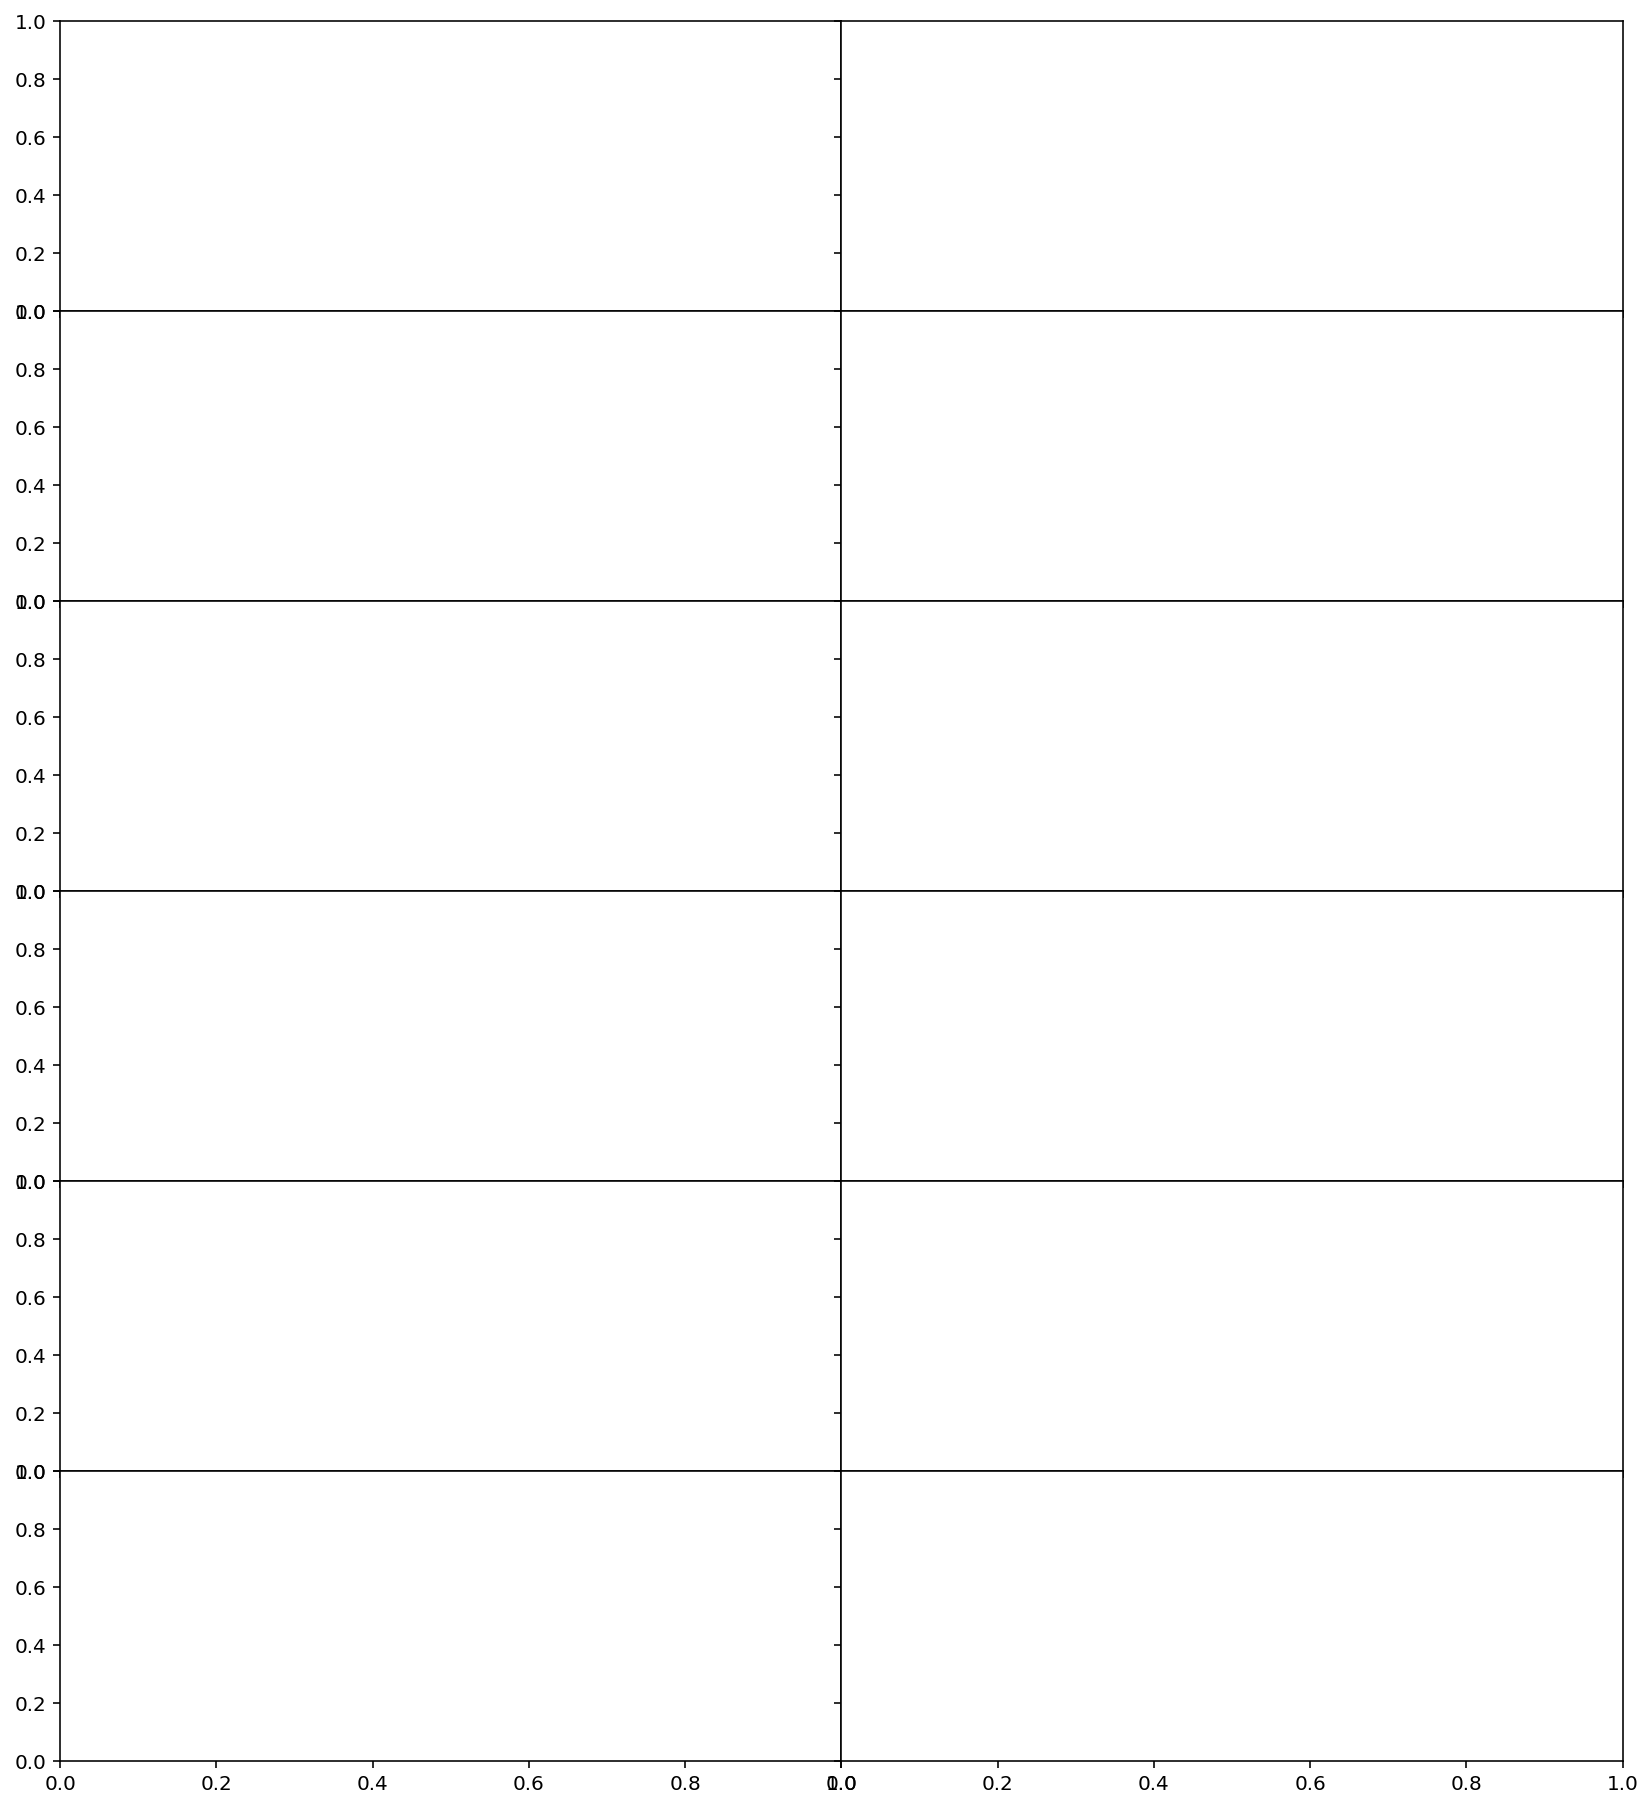

In [35]:
# Plot all incoherently time-averaged delay spectra
fig, axes = plt.subplots(6, 2, figsize=(14,16), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
ylim = (np.min(np.array(list(avg_norm_filled_spectra.values()))) / 10, 
        np.max(np.array(list(avg_norm_filled_spectra.values()))) * 2)

for i, bl, ax in zip(range(len(avg_norm_filled_spectra)), avg_norm_filled_spectra, axes.flatten()):
    ax.semilogy(F_filled.delays, avg_norm_filled_spectra[bl], label='DPSS Filled')
    ax.semilogy(F_res.delays, avg_norm_res_spectra[bl], label='DPSS Residual')
    ax.semilogy(F_res_filt.delays, avg_norm_res_filt_spectra[bl], label='DPSS Residual &\nDPSS Crosstalk Filtered')    

    ax.set_ylim(ylim)    
    ax.set_xlabel('Delay (ns)')
    
    ax.set_xlim([-1999, 1999])
    if i % 2 == 0:
        ax.set_ylabel('$|\\tilde{V}_{ij}|$ (Jy Hz)')
    
    delay_lines(ax, horizons[bl], delay_filter_half_width[bl])
    ax.legend(loc='upper left', title=bl)
plt.tight_layout()

### Figure 8: Delay Spectra, Incoherently Averaged Over The Night, of All Baselines at All Three Stages of Filtering After Coherently

## Examine Delay Spectra After Coherent Time-Averaging

In [36]:
# Perform time averaging
with contextlib.redirect_stdout(None):
    F_filled.timeavg_data(F_filled.data, F_filled.times, lsts=F_filled.lsts, t_avg=214.0, flags=F_filled.flags, nsamples=F_filled.nsamples,
                          rephase=True, wgt_by_nsample=False, wgt_by_favg_nsample=True, overwrite=True)
    F_res.timeavg_data(F_res.data, F_res.times, lsts=F_res.lsts, t_avg=214.0, flags=F_res.flags, nsamples=F_res.nsamples, 
                       rephase=True, wgt_by_nsample=False, wgt_by_favg_nsample=True, overwrite=True)
    F_res_filt.timeavg_data(F_res_filt.data, F_res_filt.times, lsts=F_res_filt.lsts, t_avg=214.0, flags=F_res_filt.flags, nsamples=F_res_filt.nsamples, 
                            rephase=True, wgt_by_nsample=False, wgt_by_favg_nsample=True, overwrite=True)

AttributeError: 'FRFilter' object has no attribute 'data'

In [37]:
# Drop last integration, which will generally be smaller and make time grids not uniform
for F in [F_filled, F_res, F_res_filt]:
    F.avg_times = F.avg_times[:-1]
    F.avg_lsts = F.avg_lsts[:-1]
    for bl in F.avg_data:
        F.avg_data[bl] = F.avg_data[bl][:-1, :]
        F.avg_flags[bl] = F.avg_flags[bl][:-1, :]
        F.avg_nsamples[bl] = F.avg_nsamples[bl][:-1, :]              

AttributeError: 'FRFilter' object has no attribute 'avg_times'

In [38]:
# Perform 1D FFTs
F_filled.fft_data(data=F_filled.avg_data, assign='avg_dfft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_res.fft_data(data=F_res.avg_data, assign='avg_dfft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_res_filt.fft_data(data=F_res_filt.avg_data, assign='avg_dfft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)

AttributeError: 'FRFilter' object has no attribute 'avg_data'

In [39]:
# Calculate incoherently time-averaged delay spectra
avg_norm_filled_spectra = calculate_avg_norm_spectra(F_filled.avg_dfft, F_filled.avg_flags, F_filled.avg_nsamples)
avg_norm_res_spectra = calculate_avg_norm_spectra(F_res.avg_dfft, F_res.avg_flags, F_res.avg_nsamples)
avg_norm_res_filt_spectra = calculate_avg_norm_spectra(F_res_filt.avg_dfft, F_res_filt.avg_flags, F_res_filt.avg_nsamples)

AttributeError: 'FRFilter' object has no attribute 'avg_dfft'

NameError: name 'avg_norm_filled_spectra' is not defined

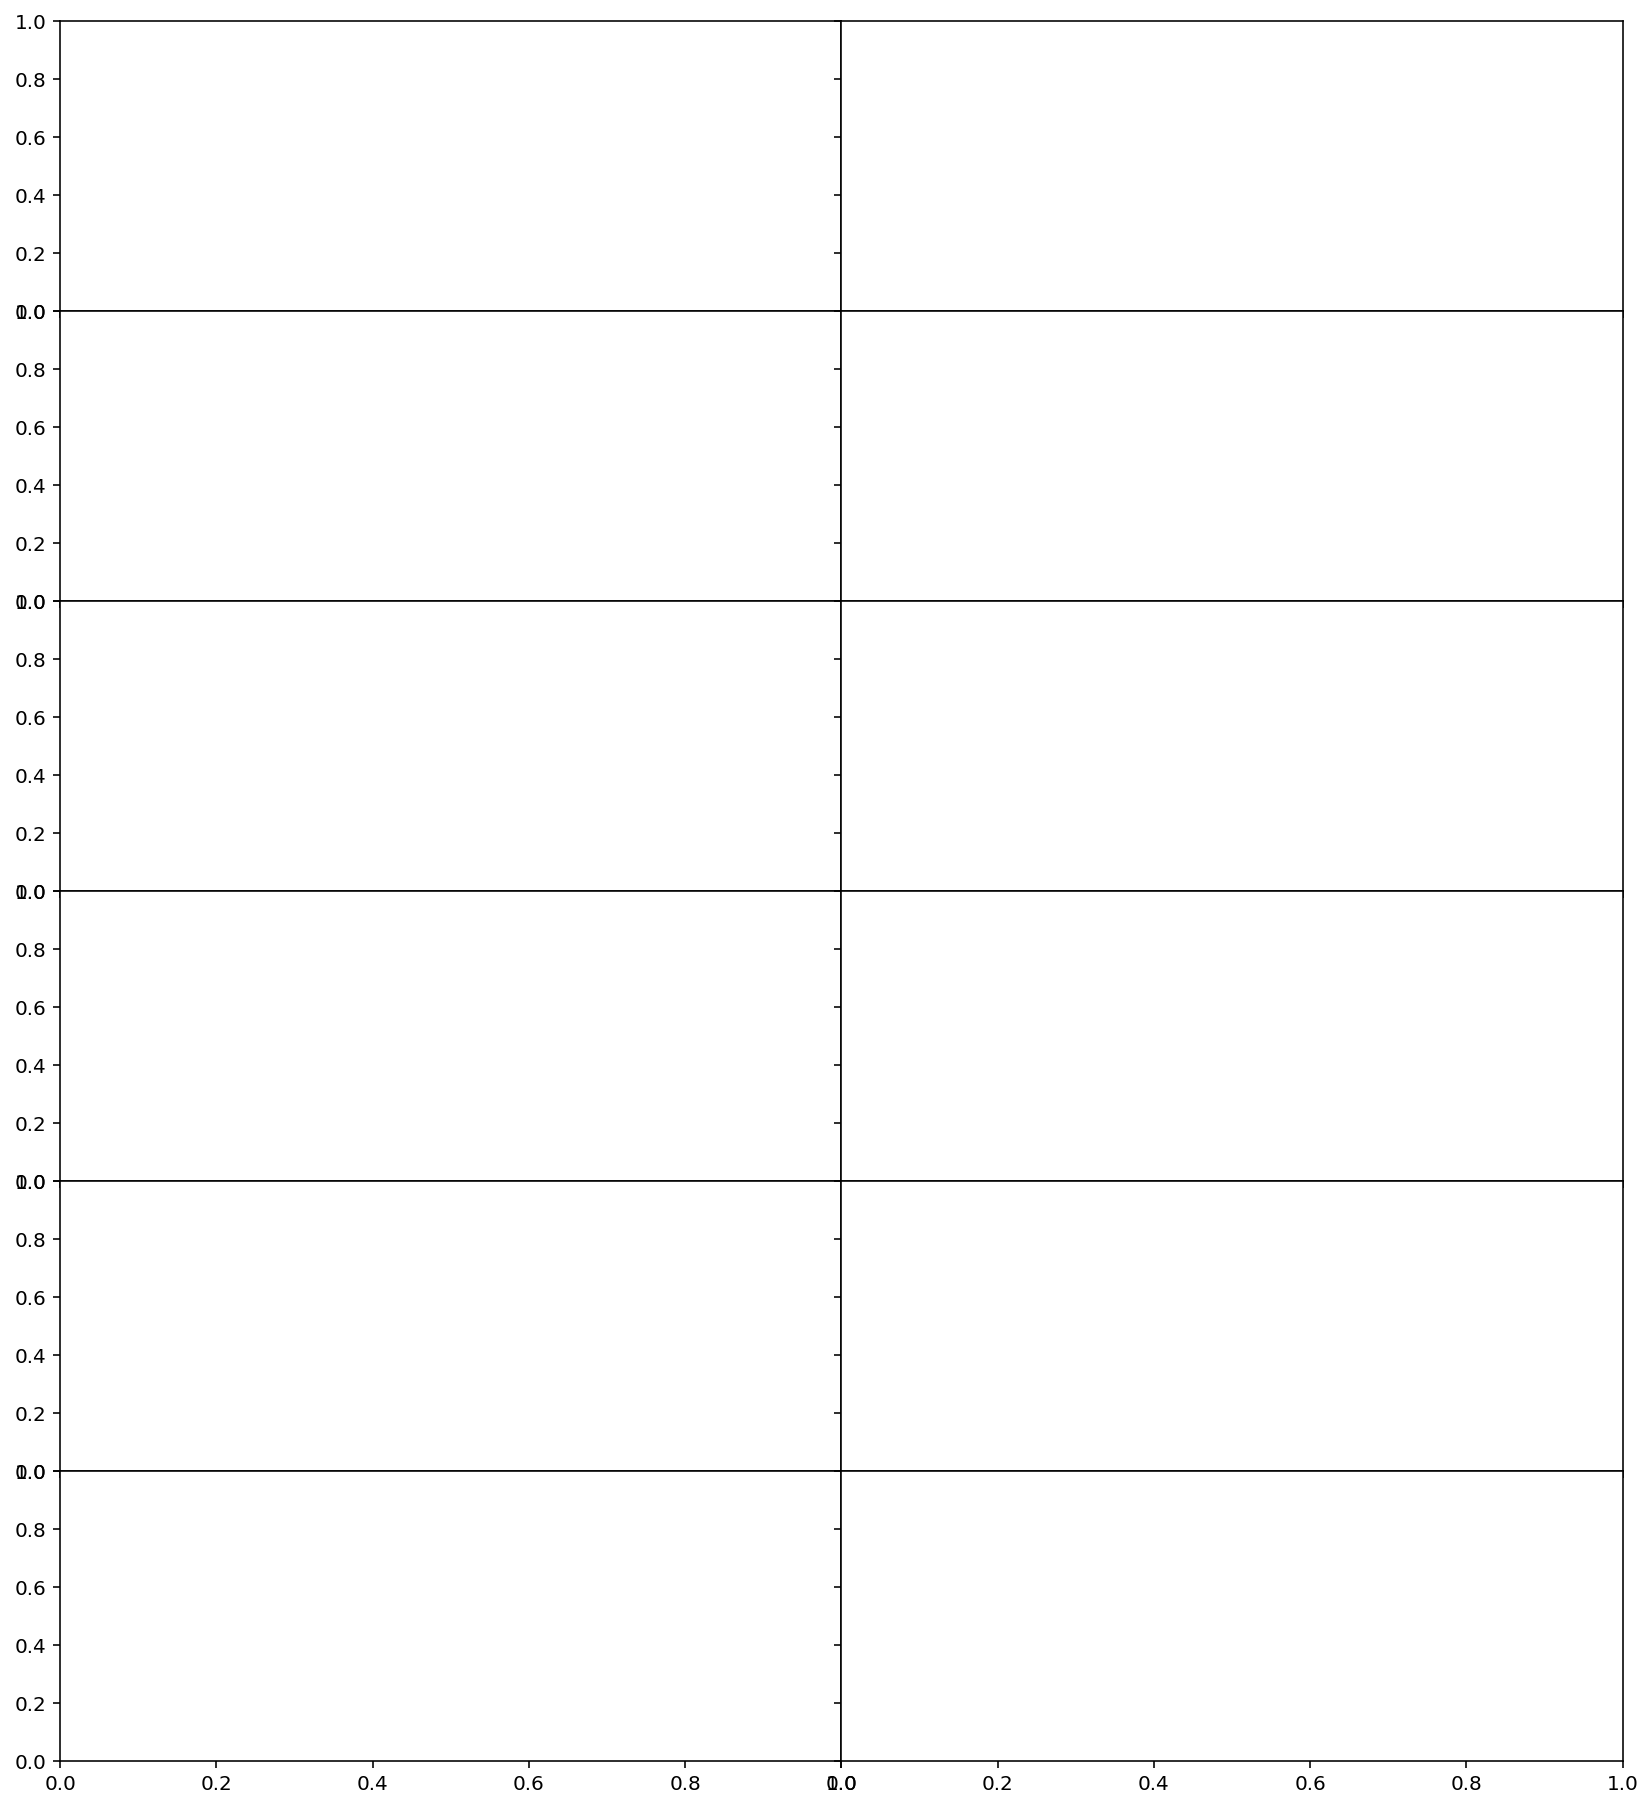

In [40]:
# Plot all incoherently time-averaged delay spectra
fig, axes = plt.subplots(6, 2, figsize=(14,16), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
ylim = (np.min(np.array(list(avg_norm_filled_spectra.values()))) / 10, 
        np.max(np.array(list(avg_norm_filled_spectra.values()))) * 2)

for i, bl, ax in zip(range(len(avg_norm_filled_spectra)), avg_norm_filled_spectra, axes.flatten()):
    ax.semilogy(F_filled.delays, avg_norm_filled_spectra[bl], label='DPSS Filled')
    ax.semilogy(F_res.delays, avg_norm_res_spectra[bl], label='DPSS Residual')
    ax.semilogy(F_res_filt.delays, avg_norm_res_filt_spectra[bl], label='DPSS Residual &\nDPSS Crosstalk Filtered')    

    ax.set_ylim(ylim)    
    ax.set_xlabel('Delay (ns)')
    
    ax.set_xlim([-1999, 1999])
    if i % 2 == 0:
        ax.set_ylabel('$|\\tilde{V}_{ij}|$ (Jy Hz)')    
    
    delay_lines(ax, horizons[bl], delay_filter_half_width[bl])    
    ax.legend(loc='upper left', title=bl)
plt.tight_layout()

### Figure 9: Delay Spectra, Incoherently Averaged Over The Night, of All Baselines at All Three Stages of Filtering After Coherently Time-Averaging

## Examine Delay Spectra After Forming Pseudo-Stokes I

In [41]:
# Form psuedo-stokes by averaging 'ee' and 'nn'
for F in [F_filled, F_res, F_res_filt]:
    F.pseudo_I = datacontainer.DataContainer({})
    F.pseudo_I_flags = datacontainer.DataContainer({})
    F.pseudo_I_nsamples = datacontainer.DataContainer({})    
    for bl in F.avg_data:
        F.pseudo_I[bl[0], bl[1], 'pI'] = 0.5 * (F.avg_data[bl[0], bl[1], 'ee'] + F.avg_data[bl[0], bl[1], 'nn'])
        F.pseudo_I_flags[bl[0], bl[1], 'pI'] = F.avg_flags[bl[0], bl[1], 'ee'] | F.avg_flags[bl[0], bl[1], 'nn']
        F.pseudo_I_nsamples[bl[0], bl[1], 'pI'] = .5 * F.avg_nsamples[bl[0], bl[1], 'ee'] + .5 * F.avg_nsamples[bl[0], bl[1], 'nn']        

AttributeError: 'FRFilter' object has no attribute 'avg_data'

In [42]:
# FFT visibilities in 1D
F_filled.fft_data(data=F_filled.pseudo_I, assign='pI_dfft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_res.fft_data(data=F_res.pseudo_I, assign='pI_dfft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)
F_res_filt.fft_data(data=F_res_filt.pseudo_I, assign='pI_dfft', ax='freq', window='bh', edgecut_low=ecf_low, edgecut_hi=ecf_high, overwrite=True)

ValueError: No keys found

In [43]:
# Recalculate the number of flagged edge times after time-averaging
avg_flag_waterfall = np.all([F_res_filt.avg_flags[bl] for bl in F_res_filt.avg_flags], axis=0)
avg_ect_low, avg_ect_high, _, _ = count_edge_flags(avg_flag_waterfall)

AttributeError: 'FRFilter' object has no attribute 'avg_flags'

In [44]:
# Add pI to filter widths
for bl in bls_to_load:
    horizons[bl[0], bl[1], 'pI'] = horizons[bl]
    delay_filter_half_width[bl[0], bl[1], 'pI'] = delay_filter_half_width[bl]    
    frf_half_width[bl[0], bl[1], 'pI'] = frf_half_width[bl]

NameError: name 'bls_to_load' is not defined

In [45]:
# Perform CLEANing in time and 2D FFT
pI_example = (example_bl[0], example_bl[1], 'pI')
F_res_filt.vis_clean(data=F_res_filt.pseudo_I, flags=F_res_filt.pseudo_I_flags, keys=[pI_example], ax='time', max_frate=5, tol=1e-6, gain=0.9,
                     window='bh', alpha=0.1, overwrite=True, verbose=True, x=F_res_filt.avg_times*24*3600, output_prefix='pI_xclean')
F_res_filt.fft_data(data=F_res_filt.pI_xclean_data, keys=[pI_example], assign='pI_xdfft2', ax='both', window=('bh','bh'), 
                    edgecut_low=(avg_ect_low, ecf_low), edgecut_hi=(avg_ect_high, ecf_high), overwrite=True)

NameError: name 'example_bl' is not defined

AttributeError: 'FRFilter' object has no attribute 'avg_lsts'

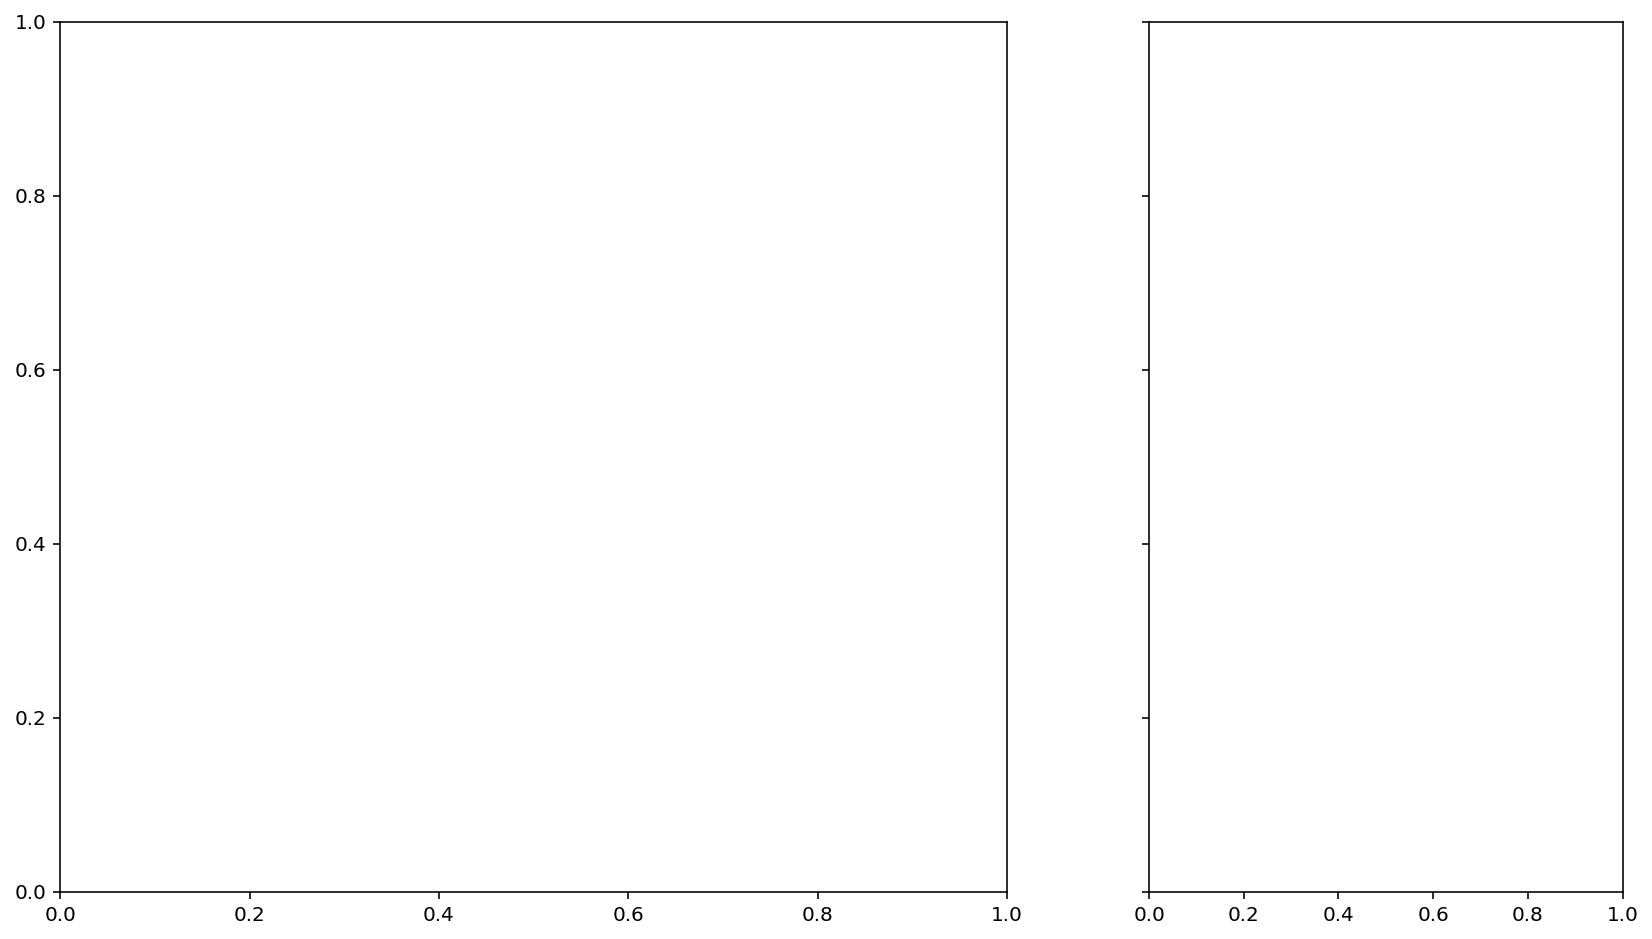

In [46]:
# plot in delay space
fig, axes = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
avg_lsts_unwrapped = np.where(F_res_filt.avg_lsts > F_res_filt.avg_lsts[-1], F_res_filt.avg_lsts - 2 * np.pi, F_res_filt.avg_lsts) * 12 / np.pi  # in hours
extent=[F_res_filt.freqs[0] / 1e6, F_res_filt.freqs[-1] / 1e6, lsts_unwrapped[-1], lsts_unwrapped[0]]

to_plot = np.where(F_res_filt.pseudo_I_flags[pI_example], np.nan, np.real(F_res_filt.pseudo_I[pI_example]))
im = axes[0].imshow(to_plot, interpolation='none', aspect='auto', cmap='bwr', extent=extent, norm=sym_log_norm(to_plot))
plt.colorbar(im, pad=.1, location='bottom', ax=axes[0], label=r'Re$[\widetilde{V}_{ij}]$ (Jy Hz)')
axes[0].set_xlabel('Delay (ns)')
axes[0].set_ylabel('LST (hours)')
axes[0].set_title(f'Final Calibrated, DPSS Residual, DPSS Crosstalk Filtered,\nTime Averaged Visibility: {pI_example}')

im = axes[1].imshow(np.where(np.all(F_res_filt.pseudo_I_flags[pI_example], axis=1, keepdims=True), np.nan, np.real(F_res_filt.pseudo_I_nsamples[pI_example])),
                    interpolation='none', aspect='auto', extent=extent)
plt.colorbar(im, pad=.1, location='bottom', ax=axes[1], label=r'Number Samples')
axes[1].set_xlabel('Frequency (MHz)')
axes[1].set_title(f'Time Averaged Number of Samples: {pI_example}')
    
plt.tight_layout()

### Figure 10a: Real Part of DPSS-Residual Example Waterfall After Crosstalk Filtering, Coherent Time Averaging, and Forming Pseudo-Stokes I

AttributeError: 'FRFilter' object has no attribute 'avg_lsts'

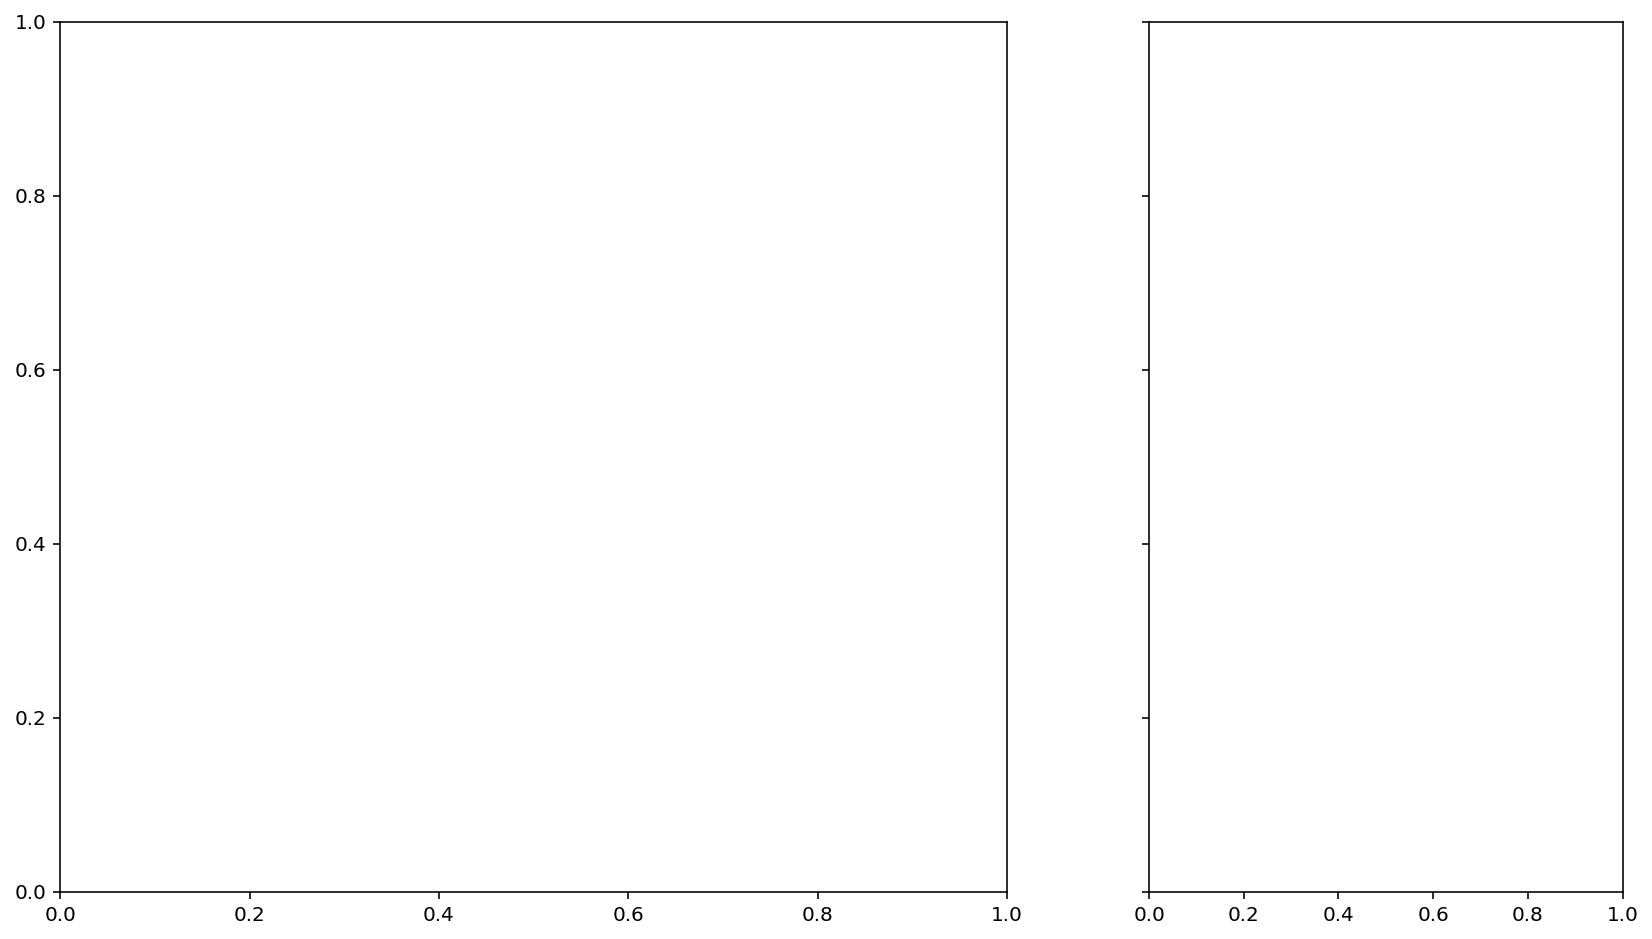

In [47]:
# plot in delay space
fig, axes = plt.subplots(1, 2, figsize=(14,8), gridspec_kw={'width_ratios': [2, 1]}, sharey=True)
avg_lsts_unwrapped = np.where(F_res_filt.avg_lsts > F_res_filt.avg_lsts[-1], F_res_filt.avg_lsts - 2 * np.pi, F_res_filt.avg_lsts) * 12 / np.pi  # in hours

to_plot = np.where(np.all(F_res_filt.pseudo_I_flags[pI_example], axis=1, keepdims=True), np.nan, np.real(F_res_filt.pI_dfft[pI_example]))
im = axes[0].imshow(to_plot, interpolation='none', aspect='auto', cmap='bwr', norm=sym_log_norm(to_plot),
                    extent=[F_res_filt.delays[0], F_res_filt.delays[-1], lsts_unwrapped[-1], lsts_unwrapped[0]])
plt.colorbar(im, pad=.1, location='bottom', ax=axes[0], label=r'Re$[\widetilde{V}_{ij}]$ (Jy Hz)')
axes[0].set_xlim([-2000, 2000])
axes[0].set_xlabel('Delay (ns)')
axes[0].set_ylabel('LST (hours)')
axes[0].set_title(f'Final Calibrated, DPSS Residual, DPSS Crosstalk Filtered,\nTime Averaged Visibility: {pI_example}')
delay_lines(axes[0], horizons[pI_example], delay_filter_half_width[pI_example])
axes[0].legend()

im = axes[1].imshow(np.where(np.all(F_res_filt.pseudo_I_flags[pI_example], axis=1, keepdims=True), np.nan, np.real(F_res_filt.pseudo_I_nsamples[pI_example])),
                    interpolation='none', aspect='auto', extent=[F_res_filt.freqs[0] / 1e6, F_res_filt.freqs[-1] / 1e6, lsts_unwrapped[-1], lsts_unwrapped[0]])
plt.colorbar(im, pad=.1, location='bottom', ax=axes[1], label=r'Number Samples')
axes[1].set_xlabel('Frequency (MHz)')
axes[1].set_title(f'Time Averaged Number of Samples: {pI_example}')
    
plt.tight_layout()

### Figure 10b: Real Part of DPSS-Residual Example Waterfall After Crosstalk Filtering, Coherent Time Averaging, and Forming Pseudo-Stokes I in Delay Space

In [48]:
# plot in delay space and FR space
frates = np.fft.fftshift(np.fft.fftfreq(len(F_res_filt.avg_times), np.median(np.diff(F_res_filt.avg_times)) * 24 * 3600) * 1e3) # in mHz

extent = [F_res_filt.delays[0], F_res_filt.delays[-1], frates[-1], frates[0]]
plt.figure(figsize=(14,8))
plt.imshow(np.abs(F_res_filt.pI_xdfft2[pI_example]), aspect='auto', interpolation='none', 
           norm=matplotlib.colors.LogNorm(), cmap='jet', extent=extent)
plt.colorbar(label='$|\widetilde{V}_{ij}|$ (Jy)')
plt.xlabel('Delay (ns)')
plt.xlim([-2000, 2000])
plt.ylabel('Fringe Rate (mHz)')
plt.title(f'Final Calibrated, DPSS Residual, DPSS Crosstalk Filtered, and CLEAN Inpainted (in Time): {pI_example}')
delay_lines(plt.gca(), horizons[pI_example], delay_filter_half_width[pI_example])
fr_lines(plt.gca(), frf_half_width[pI_example])
plt.legend()
plt.tight_layout()

AttributeError: 'FRFilter' object has no attribute 'avg_times'

### Figure 10c: Magnitude of DPSS-Residual Example Waterfall After Crosstalk Filtering, Coherent Time Averaging, and Forming Pseudo-Stokes I in Fringe-Rate / Delay Space

In [49]:
# Calculate incoherently time-averaged delay spectra
avg_norm_filled_spectra = calculate_avg_norm_spectra(F_filled.pI_dfft, F_filled.pseudo_I_flags, F_filled.pseudo_I_nsamples)
avg_norm_res_spectra = calculate_avg_norm_spectra(F_res.pI_dfft, F_res.pseudo_I_flags, F_res.pseudo_I_nsamples)
avg_norm_res_filt_spectra = calculate_avg_norm_spectra(F_res_filt.pI_dfft, F_res_filt.pseudo_I_flags, F_res_filt.pseudo_I_nsamples)

AttributeError: 'FRFilter' object has no attribute 'pI_dfft'

ValueError: zero-size array to reduction operation minimum which has no identity

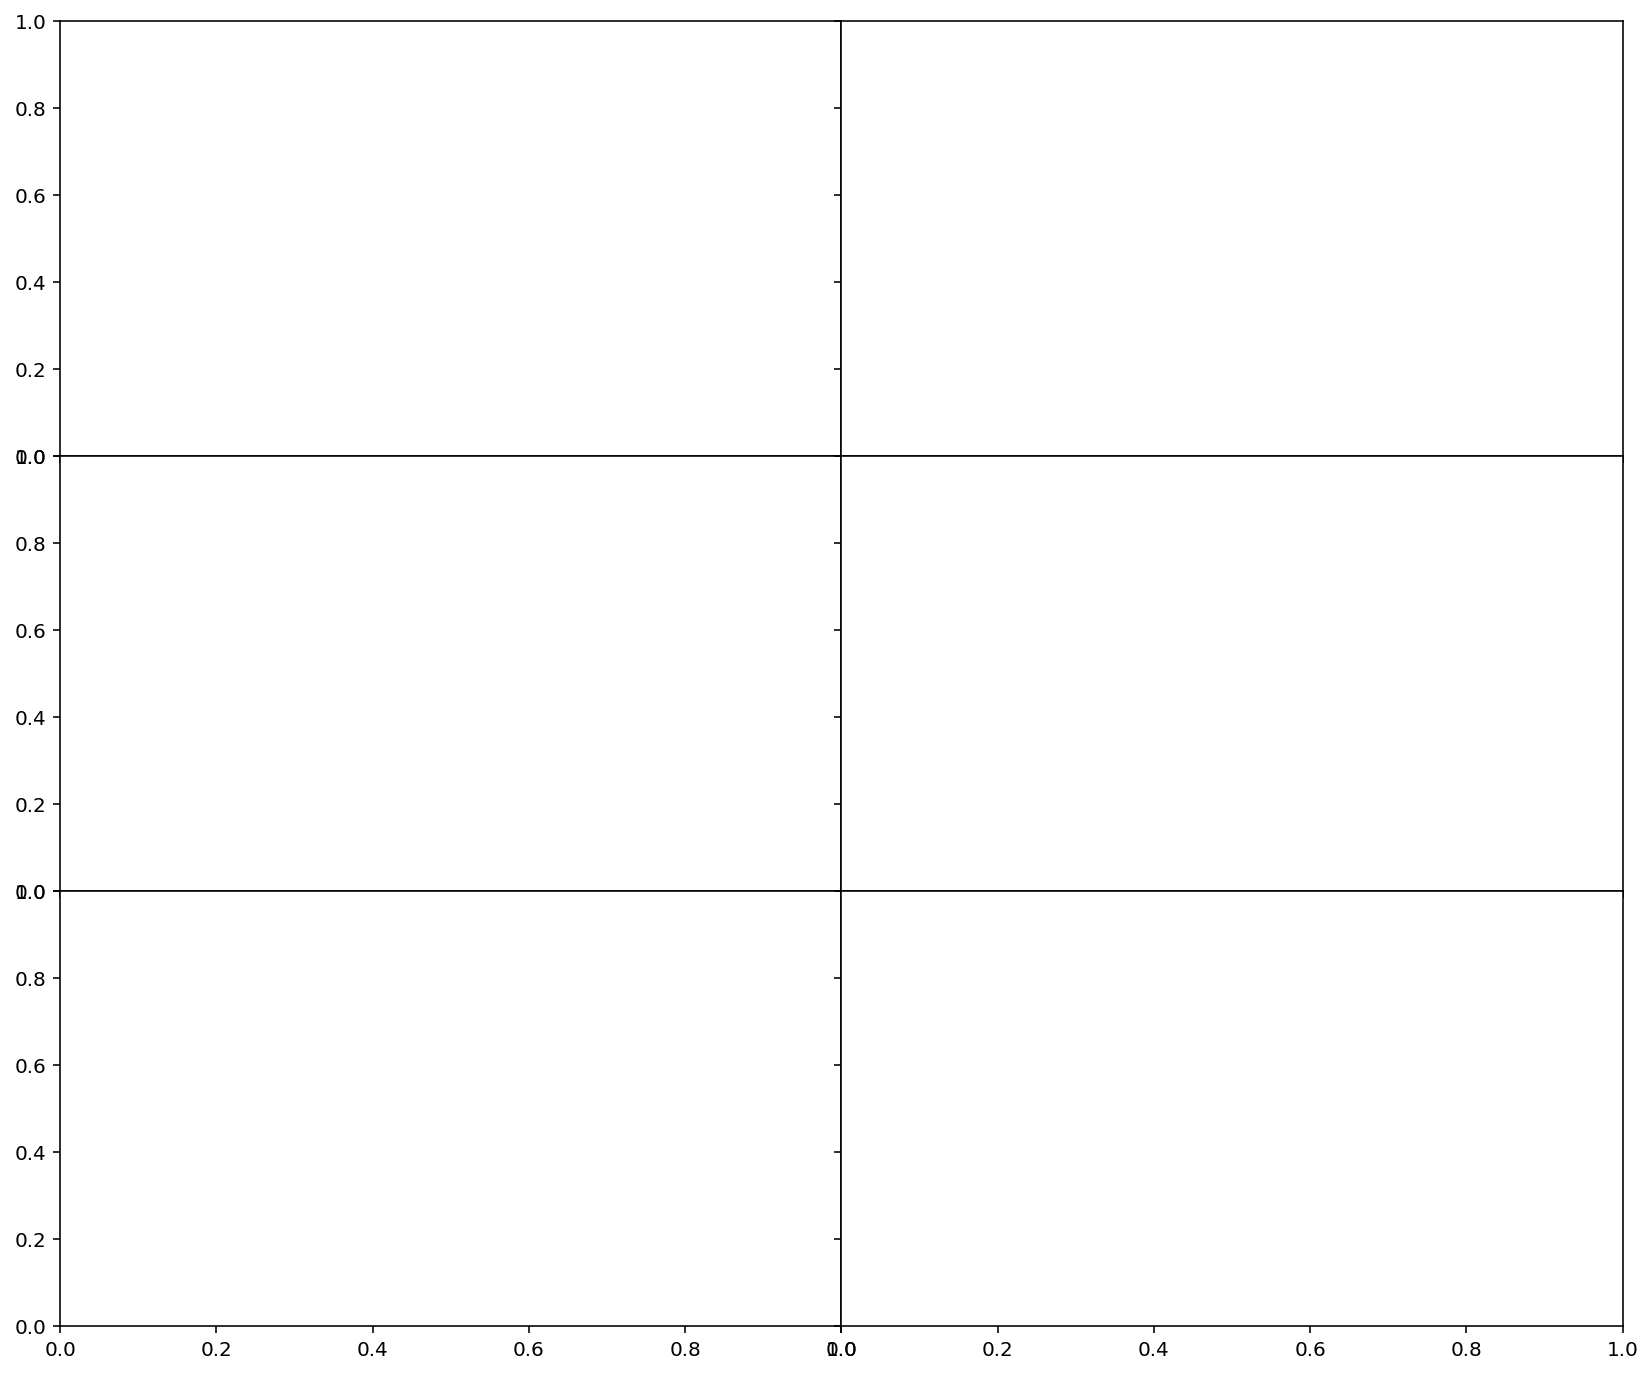

In [50]:
# Plot all incoherently time-averaged delay spectra
fig, axes = plt.subplots(3, 2, figsize=(14,12), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
ylim = (np.min(np.array(list(avg_norm_filled_spectra.values()))) / 10, 
        np.max(np.array(list(avg_norm_filled_spectra.values()))) * 2)

for i, bl, ax in zip(range(len(avg_norm_filled_spectra)), avg_norm_filled_spectra, axes.flatten()):
    ax.semilogy(F_filled.delays, avg_norm_filled_spectra[bl], label='DPSS Filled')
    ax.semilogy(F_res.delays, avg_norm_res_spectra[bl], label='DPSS Residual')
    ax.semilogy(F_res_filt.delays, avg_norm_res_filt_spectra[bl], label='DPSS Residual &\nDPSS Crosstalk Filtered')    

    ax.set_ylim(ylim)    
    ax.set_xlabel('Delay (ns)')
    ax.set_xlim([-1999, 1999])
    if i % 2 == 0:
        ax.set_ylabel('$|\\tilde{V}_{ij}|$ (Jy Hz)')    
    delay_lines(ax, horizons[bl], delay_filter_half_width[bl])    
    ax.legend(loc='upper left', title=bl)
plt.tight_layout()

### Figure 11: Delay Spectra, Incoherently Averaged Over The Night, of All Baselines at All Three Stages of Filtering After Coherently Time-Averaging and Forming Pseudo-Stokes I

In [51]:
from hera_cal import version
print(version.history_string())


------------
This file was produced by the function <module>() in 2408815014.py using: 
    git_branch: increased-filter-control
    git_description: v3.0-1854-ge649ef1b
    git_hash: e649ef1b980319c68e20d3536e0da97c405846df
    git_origin: git@github.com:HERA-Team/hera_cal.git
    version: 3.0
------------

